<h1> Coursework 2: Generative Models </h1>

# Part 0 - Setup

## Introduction

In this coursework, you will build a generative latent diffusion model from scratch. Initially, you'll learn to create robust embeddings using a VAE. However, due to resource limitations, creating high-quality embeddings this way will prove too costly. Instead, we will use a pre-existing image encoder-decoder model from the backbone of Stable Diffusion 2. Based on this, you will train a latent diffusion model (Denoising Diffusion Probabilistic Models - DDPM with pretrained VAE latent embeddings). We will generate new images from pure noise, without prompt conditioning or other frills.

Our goal is inspired by the famous hot-dog detector from the TV show Silicon Valley ([YouTube](https://www.youtube.com/watch?v=vIci3C4JkL0)), which turned out to be a more challenging machine learning problem than the show's creators might have anticipated. You will train a hot-dog generator using a clean and highly curated dataset. Afterwards, you'll test your model with a hot-dog detector we've provided to see if it can produce plausible hot-dog images.

Please manage your expectations regarding image quality. Two examples from our training runs are shown below. We are working with smaller image sizes and have optimized this task for the available GPU resources and limited training time. If done correctly, you should be able to generate images that somewhat resemble hot dogs after only a few hours of training. For context, current generative models like Stable Diffusion require many days of training on large clusters, which is beyond the scope of this course. Nevertheless, this exercise will also introduce you to the use of large-scale GPU resources and their operation from a developer's perspective on a cluster.


<img src="https://www.doc.ic.ac.uk/~bkainz/teaching/DL/best_example.png" alt="Hot-dog Generator Model" width="200">
<img src="https://www.doc.ic.ac.uk/~bkainz/teaching/DL/average_example.png" alt="Hot-dog Generator Model" width="200">

*Figure 1: One of the better Hot-dogs we managed to generate on small infrastructre (left) and an average result after 2h training (right).*


## Submission 
Submissions will be done via LabTS (https://teaching.doc.ic.ac.uk/labts), similar to coursework 1. Please push your solution well in time and start early to avoid resource bottlenecks closer to the deadline. 

This notebook can be found in your gitlab LabTS generated gitlab repository. We also require you to clone our minimal base environment from https://github.com/bkainz/icl_dl_cw2_utils as automatically done when setting up the environment in code box 1. 

## Training
Training the VAE and DDPM will take quite a long time (some hours), please refer to the DoC GPU options detailed in the logistics lecture (https://www.doc.ic.ac.uk/~bkainz/teaching/DL/L01_logistics_lecture.pdf).

## Testing
TAs will run a testing cell (at the end of this notebook), so you are required to copy your data ```transform``` and ```denorm``` functions to a cell near the bottom of the document (it is demarkated). You are advised to check that your implementations pass these tests (in particular, the jit saving and loading may not work for certain niche functions). 

The VAE and the DDPM are separate parts so that you can manage your time. Each can yield 50% of the marks but they do not depend on each other for successful completion.

The DDPM will be tested with a hot-dog detector trained on https://universe.roboflow.com/workspace-2eqzv/hot-dog-detection/dataset/2 and https://www.kaggle.com/datasets/dansbecker/food-101. If one of your generated images is within the top-5 predicitons, save it and add to your repository. Your work is done at this point and if you implemented both parts correctly you will get 100% of the marks. 

## General
Feel free to add architectural alterations / custom functions outside of pre-defined code blocks. However, if you manipulate the model's inputs in some way, please include the same code in the TA test cell, so our tests will run easily.

The emphasis of both parts lies in understanding how the models behave and learn, however, some points will be available for getting good results with your LDM NOTE: you should not spend too long on this! Reasonable results are sufficent. It takes massive infrastructure and many GPU hours to train models like stable diffusion, so do NOT try to compete at this level here!

## Setting up working environment
You will need to install pytorch and import some utilities by running the following cell:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib.util
# Dictionary mapping package names to their pip install names
packages = {
    'torch': 'torch torchvision altair seaborn',
    'accelerate': 'accelerate', 
    'huggingface_hub': '--upgrade huggingface_hub',
    'ipywidgets': 'ipywidgets',
    'sklearn': 'scikit-learn',
    'tqdm': 'tqdm',
    'transformers': 'transformers',
    'diffusers': 'diffusers[torch]',
    'einops': 'einops'
}

# Check which packages are missing
missing_packages = []
for package, pip_name in packages.items():
    if importlib.util.find_spec(package) is None:
        missing_packages.append(pip_name)

# Install all missing packages in a single pip call
if len(missing_packages) > 0:
    !pip install {' '.join(packages.values())}

import os
if not os.path.exists('icl_dl_cw2_utils'):
    !git clone -q https://github.com/bkainz/icl_dl_cw2_utils


In [3]:
import tqdm
import os
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler

from icl_dl_cw2_utils.utils.hotdogdataset import DLHotDogDataset
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid


In [5]:
# Check available CUDA devices and memory
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    for i in range(num_devices):
        device = torch.cuda.device(i)
        total_mem = torch.cuda.get_device_properties(i).total_memory / 1024**3  # Convert to GB
        allocated_mem = torch.cuda.memory_allocated(i) / 1024**3  # Convert to GB
        free_mem = total_mem - allocated_mem
        
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Total Memory: {total_mem:.1f}GB")
        print(f"Allocated Memory: {allocated_mem:.1f}GB")
        print(f"Free Memory: {free_mem:.1f}GB")
        
        if free_mem < 8:
            print(f"Warning: GPU {i} has less than 8GB of free VRAM!")
        else:
            print(f"Using GPU {i} with {free_mem:.1f}GB free VRAM")
            break 
    device = torch.device(f"cuda:{i}")
else:
    print("Warning: No CUDA devices available - running on CPU only")
    device = torch.device("cpu")


GPU 0: NVIDIA A100 80GB PCIe MIG 1g.10gb
Total Memory: 9.5GB
Allocated Memory: 0.0GB
Free Memory: 9.5GB
Using GPU 0 with 9.5GB free VRAM


Here we have some default pathing options which vary depending on the environment you are using. You can of course change these as you please.

In [6]:
# Initialization Cell
WORKING_ENV = 'LABS' # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
USERNAME = 'ad524' # If working on Lab Machines - Your college username
assert WORKING_ENV in ['DOCCLUSTER', 'LABS', 'COLAB', 'LOCAL']
                       
if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    dl_cw2_repo_path = 'dl_cw2/' # path in your gdrive to the repo
    content_path = f'/content/drive/MyDrive/{dl_cw2_repo_path}' # path to gitrepo in gdrive after mounting
    data_path = './data/' # save the data locally
    drive.mount('/content/drive/') # Outputs will be saved in your google drive

elif WORKING_ENV == 'LABS' or WORKING_ENV == 'DOCCLUSTER':
    content_path = f'/vol/bitbucket/{USERNAME}/DL_CW_2_ad524/dl_cw2/' # You may want to change this dl
    data_path = f'/vol/bitbucket/{USERNAME}/DL_CW_2_ad524/data'
    # Your python env and training data should be on bitbucket
    if 'vol/bitbucket' not in content_path or 'vol/bitbucket' not in data_path:
        import warnings
        warnings.warn(
           'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues')
               
elif WORKING_ENV == 'LOCAL':
    content_path = f'./dl/dl_cw2/' # You may want to change this
    data_path = f'./dl/data'
    os.makedirs(content_path, exist_ok=True)
    os.makedirs(data_path, exist_ok=True)
    # Your python env and training data should be on bitbucket
    if './dl/dl_cw2/' not in content_path or './dl/data' not in data_path:
        import warnings
        warnings.warn(
           'You know best what to do on your local machine')

else:
  raise NotImplementedError()

content_path = Path(content_path)
os.makedirs(content_path/'CW_VAE/', exist_ok=True)
os.makedirs(content_path/'CW_LDM/', exist_ok=True)
print(content_path)

/vol/bitbucket/ad524/DL_CW_2_ad524/dl_cw2


In [7]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def show(img):
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)))

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
    print('you are using only the CPU. Please make sure that you train models on a GPU.')
print(f'Using {device}')

Using cuda


# Part 1 - Variational Autoencoder (50 points)

 ## Part 1.1 - Implementation and training (20 points)
 
 **Background:**
 
 Variational Autoencoders (VAEs) are generative models that learn to encode data into a lower-dimensional latent space and decode it back to reconstruct the original data. Unlike regular autoencoders, VAEs learn a probabilistic mapping by encoding inputs as distributions (typically Gaussian) in the latent space.

 The VAE architecture consists of:
 - An encoder network that maps input x to parameters (μ, σ) of the latent distribution q(z|x)
 - A sampling operation that draws latent vectors z from this distribution 
 - A decoder network that reconstructs the input from z

 The loss function has two components:
 - Reconstruction loss: How well the decoder reconstructs the input
 - KL divergence loss: Ensures the latent distribution matches a prior p(z)

 **Your Task:**
 
 a. Implement a VAE with:
 - A convolutional encoder network that outputs μ and σ for the latent distribution
 - A sampling layer using the reparameterization trick
 - A convolutional decoder network
 - Appropriate hyperparameters (latent dimension, layer sizes etc.)

 More marks will be awarded for using convolutional layers vs. fully connected layers, as CNNs are better suited for image data.
 
 b. Implement the VAE loss function combining:
 - Reconstruction loss (e.g. Binary Cross Entropy for MNIST)
 - KL divergence between q(z|x) and p(z)
 Then train the model and visualize results.
 
 You will first implement and train the VAE on the MNIST dataset of handwritten digits. After validating your implementation, you will extend it to work with a more complex dataset of hot dog images.

 The following sections will guide you through:
 - Setting up the architecture
 - Implementing the loss function  
 - Training the model
 - Analyzing the latent space
 - Generating new samples
 
 ---

### Part 1.1a - Implement VAE (10 Points)

#### Hyper-parameter selection

<!-- BEGIN QUESTION -->



In [8]:
# Necessary Hyperparameters 
num_epochs = 16
learning_rate = 0.01 #0.03
batch_size = 128
latent_dim = 20 # Choose a value for the size of the latent space

# Additional Hyperparameters 
beta = 5
lr_gamma = 0.1
lr_step_size = 7

# Mean and std of the training data
mean = 0.1307
std = 0.3081

# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(),
    # Don't normalise since we will use the Binary Cross-Entropy loss
    # as the data is nearly binary (see histogram plot in "Defining a Loss" section)
    #transforms.Normalize(mean, std),

    # We could add some data augmentation here (eg random rotations)
    # but to keep it simple we won't
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    #transforms.Normalize(-mean/std, 1/std)
    return x

#### Data loading

In [9]:
train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change 
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path/'CW_VAE/image_original.png')



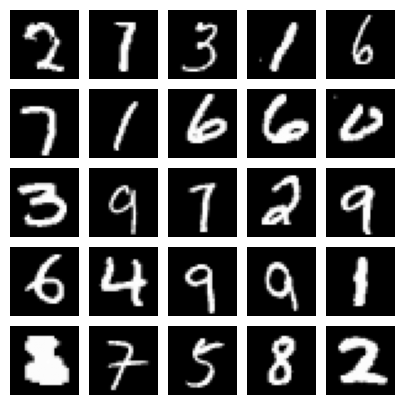

In [12]:
from mpl_toolkits.axes_grid1 import ImageGrid
# get 25 sample training images for visualization
dataiter = iter(loader_train)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [13]:
print(train_dat)
print(test_dat)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /vol/bitbucket/ad524/DL_CW_2_ad524/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: /vol/bitbucket/ad524/DL_CW_2_ad524/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


 #### Model Definition
 
 <figure>
   <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
   <figcaption>
     Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">1</a>.
   </figcaption>
 </figure>
 
 A Variational Autoencoder (VAE) consists of several key components:
 * Encoder: Compresses input data into a lower dimensional latent space
 * Reparametrization: Samples from the latent distribution in a differentiable way
 * Decoder: Reconstructs the original input from the latent representation

 You will need to define:
 * The hyperparameters - Control model capacity and training behavior
 * The constructor - Initialize model architecture and layers
 * encode - Maps input to mean and log variance of latent distribution
 * reparametrize - Samples latent vectors using reparametrization trick
 * decode - Maps latent vectors back to input space
 * forward - Combines all components into full forward pass
 
 Requirements:
 * This model MUST NOT have more than 1M parameters
 
 Hints:
 - It is common practice to encode the log of the variance, rather than the variance
   (This improves numerical stability during training)
 - You might try using BatchNorm
   (This can help stabilize training and reduce internal covariate shift)

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, 
                 latent_dim=10,
                 conv_channels=[16, 32, 64],  # Number of channels in each conv layer
                 conv_kernel_size=3,
                 hidden_dims=[128, 64]):  # Dimensions of hidden linear layers
        """
        Variational Autoencoder specifically designed for MNIST dataset.
        
        Args:
            latent_dim (int): Dimension of the latent space
            conv_channels (list): Number of channels in each conv layer
            conv_kernel_size (int): Size of convolutional kernels
            hidden_dims (list): Dimensions of hidden linear layers
            
        Input:
            x: Tensor of shape (batch_size, 1, 28, 28) - MNIST images
        """
        super(VAE, self).__init__()
        
        # MNIST specific parameters
        self.input_channels = 1  # grayscale
        self.input_size = 28    # MNIST image size
        self.latent_dim = latent_dim
        
        # Calculate size after convolutions
        conv_output_size = self.input_size
        for _ in range(len(conv_channels)):
            conv_output_size = conv_output_size - (conv_kernel_size - 1)
        self.conv_output_size = conv_output_size
        
        # ENCODER
        # Convolutional layers
        self.encoder_conv = nn.ModuleList()
        self.encoder_bn = nn.ModuleList()
        
        in_channels = self.input_channels
        for out_channels in conv_channels:
            self.encoder_conv.append(
                nn.Conv2d(in_channels, out_channels, conv_kernel_size)
            )
            self.encoder_bn.append(nn.BatchNorm2d(out_channels))
            in_channels = out_channels
            
        # Calculate flattened size
        self.flatten_size = conv_channels[-1] * conv_output_size * conv_output_size
        
        # Linear layers
        self.encoder_linear = nn.ModuleList()
        dims = [self.flatten_size] + hidden_dims
        
        for i in range(len(dims)-1):
            self.encoder_linear.append(
                nn.Linear(dims[i], dims[i+1])
            )
            
        # Latent space layers
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        # DECODER
        # Linear layers
        self.decoder_linear = nn.ModuleList()
        dims = [latent_dim] + hidden_dims[::-1] + [self.flatten_size]
        
        for i in range(len(dims)-1):
            self.decoder_linear.append(
                nn.Linear(dims[i], dims[i+1])
            )
            
        # Transposed convolutional layers
        self.decoder_conv = nn.ModuleList()
        reversed_channels = conv_channels[::-1]
        
        in_channels = conv_channels[-1]
        for out_channels in reversed_channels[1:]:
            self.decoder_conv.append(
                nn.ConvTranspose2d(in_channels, out_channels, conv_kernel_size)
            )
            in_channels = out_channels
            
        # Final transposed convolution to get back to MNIST dimensions
        self.final_conv = nn.ConvTranspose2d(
            reversed_channels[-1], self.input_channels, conv_kernel_size
        )
        
    def encode(self, x):
        """
        Encode input images into the latent space.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)
            
        Returns:
            tuple: (mu, logvar) of the latent space distribution
        """
        # Convolutional layers
        for conv, bn in zip(self.encoder_conv, self.encoder_bn):
            x = F.relu(bn(conv(x)))
            
        # Flatten
        x = torch.flatten(x, start_dim=1)
        
        # Linear layers
        for linear in self.encoder_linear:
            x = F.relu(linear(x))
            
        # Latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """
        Perform the reparameterization trick.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """
        Decode latent vectors into MNIST images.
        
        Args:
            z (torch.Tensor): Latent vectors
            
        Returns:
            torch.Tensor: Reconstructed images of shape (batch_size, 1, 28, 28)
        """
        # Linear layers
        for i, linear in enumerate(self.decoder_linear):
            z = F.relu(linear(z))
            
        # Reshape for convolution
        z = z.view(-1, self.encoder_conv[-1].out_channels, 
                  self.conv_output_size, self.conv_output_size)
        
        # Transposed convolutions
        for conv in self.decoder_conv:
            z = F.relu(conv(z))
            
        # Final layer
        z = self.final_conv(z)
        return torch.sigmoid(z)
    
    def forward(self, x):
        """
        Forward pass through the VAE.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)
            
        Returns:
            tuple: (reconstructed_x, mu, logvar)
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Example usage for MNIST:

# Initialize model
model_config = {
    'latent_dim': 10,
    'conv_channels': [8, 16, 32],
    'conv_kernel_size': 3,
    'hidden_dims': [16, 8]
}

model = VAE(**model_config).to(device)
# model = VAE(latent_dim).to(device)
# Print model summary
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

# Optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 523525
VAE(
  (encoder_conv): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  )
  (encoder_bn): ModuleList(
    (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder_linear): ModuleList(
    (0): Linear(in_features=15488, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
  )
  (fc_mu): Linear(in_features=8, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=8, out_features=10, bias=True)
  (decoder_linear): ModuleList(
    (0): Linear(in_features=10, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=16, bias=True)
    (2): Linear(i

In [59]:
import otter
grader = otter.Notebook("dl_cw2.ipynb")
grader.check("Q1.1a Implement VAE")

Q1.1a Implement VAE results: All test cases passed!
Q1.1a Implement VAE - 1 message: Model Size Test Passed

In [ ]:
# # *CODE FOR PART 1.1a IN THIS CELL*

# # Define any deep CNN/MLP network class here if needed
# ...

# class VAE(nn.Module):
#     def __init__(self, channels, latent_dim):
#         super(VAE, self).__init__()
#         #######################################################################
#         #                       ** START OF YOUR CODE **
#         #######################################################################
#         ...
#         #######################################################################
#         #                       ** END OF YOUR CODE **
#         ####################################################################### 
    
#     # We provide with a helper function in case it is useful
#     def make_layer_encode(self, block, in_channel, out_channel, stride, num_blocks, expand_ratio):
#         layers = []
#         for i in range(num_blocks):
#             if i == 1:
#                 s = stride
#             else:
#                 s = 1
#             layers.append(block(in_channel, out_channel, s, expand_ratio))
#             in_channel = out_channel
#         return nn.Sequential(*layers)    

#     def encode(self, x):
#         #######################################################################
#         #                       ** START OF YOUR CODE **
#         #######################################################################
#         ...
#         return mu, logvar
#         #######################################################################
#         #                       ** END OF YOUR CODE **
#         ####################################################################### 
    
#     def reparametrize(self, mu, logvar):
#         #######################################################################
#         #                       ** START OF YOUR CODE **
#         #######################################################################
#         ...
#         return z
#         #######################################################################
#         #                       ** END OF YOUR CODE **
#         ####################################################################### 

#     def decode(self, z):
#         #######################################################################
#         #                       ** START OF YOUR CODE **
#         #######################################################################
#         ...
#         #######################################################################
#         #                       ** END OF YOUR CODE **
#         ####################################################################### 
#         return z
    
#     def forward(self, x):
#         #######################################################################
#         #                       ** START OF YOUR CODE **
#         #######################################################################
#         ...
#         #######################################################################
#         #                       ** END OF YOUR CODE **
#         ####################################################################### 
#         return out, mu, logvar

# model = VAE(1, latent_dim).to(device)
# params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print("Total number of parameters is: {}".format(params))
# print(model)
# # optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 1021233
VAE(
  (convolution_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (batch_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convolution_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convolution_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (linear_layer_1): Linear(in_features=15488, out_features=32, bias=True)
  (linear_layer_2): Linear(in_features=32, out_features=16, bias=True)
  (linear_layer_mu): Linear(in_features=16, out_features=32, bias=True)
  (linear_layer_logvar): Linear(in_features=16, out_features=32, bias=True)
  (linear_layer_4): Linear(in_features=32, out_features=16, bias=True)
  (linear_layer_5): Linear(in_features=16, out_features=32, bias=True)
  (linear_layer_6): Linear(in_features=32, out_features=15488, bias=True)
  (transpose_convolution_1): ConvTranspose2d(32, 16, kerne

<!-- END QUESTION -->

---

### Part 1.1b - Training the Model (5 Points)

#### Defining a Loss
Recall the Beta VAE loss, with an encoder $q$ and decoder $p$:
$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

In order to implement this loss you will need to think carefully about your model's outputs and the choice of prior.

There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training

* This will take between 5-20 min training time for 15 epochs.

In [62]:
# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(recon_x, x, mu, logvar, beta):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        NLL = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return NLL + (beta*KLD), NLL, KLD

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

model = VAE(**model_config).to(device)
model_path = f"./VAE_model_{latent_dim}.pth"

 #optional -- do this if you want to continue training on a previous training run
load_checkpoint = False
if os.path.exists(model_path) and load_checkpoint:
    print("loading existing model...")
    model.load_state_dict(torch.load(model_path))
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
test_losses = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = lr_step_size, gamma = lr_gamma)

num_epochs = 15 #! For testing
beta = 5
for epoch in range(num_epochs):     
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
       
        total_loss, total_NLL_loss, total_KLD_loss = 0, 0, 0
        model.train()
        for data, y in loader_train:
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass
            recon_x, mu, logvar = model(data)
            
            # Compute loss
            loss, NLL, KLD = loss_function_VAE(recon_x, data, mu, logvar, beta)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Accumulate losses
            total_loss += loss.item()
            total_NLL_loss += NLL.item()
            total_KLD_loss += KLD.item()
            
        train_losses.append([total_loss / len(loader_train.dataset), total_NLL_loss / len(loader_train.dataset), total_KLD_loss / len(loader_train.dataset)])

        # Testing phase
        total_loss, total_NLL_loss, total_KLD_loss = 0, 0, 0
        model.eval()
        with torch.no_grad():
            for data, y in loader_test:
                data = data.to(device)  # Flatten MNIST images
                    
                # Forward pass
                recon_x, mu, logvar = model(data)
                
                # Compute loss
                loss, NLL, KLD = loss_function_VAE(recon_x, data, mu, logvar, beta)
                
                # Accumulate losses
                total_loss += loss.item()
                total_NLL_loss += NLL.item()
                total_KLD_loss += KLD.item()

        test_losses.append([total_loss / len(loader_test.dataset), total_NLL_loss / len(loader_test.dataset), total_KLD_loss / len(loader_test.dataset)])
        lr = optimizer.param_groups[0]['lr']
        print(f'Epoch: {epoch}, train loss = {train_losses[-1][0]:.2f}, test loss = {test_losses[-1][0]:.2f}, lr = {lr:.5f}')

        scheduler.step()

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        # save the model
        if epoch % 5 == 0:
            with torch.no_grad():
                torch.save(model.state_dict(), model_path)
                
        if epoch == num_epochs - 1:
            with torch.no_grad():
                torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                    'VAE_model_jit.pth')

Epoch: 0, train loss = 243.76, test loss = 201.20, lr = 0.00100
Epoch: 1, train loss = 199.03, test loss = 196.50, lr = 0.00100
Epoch: 2, train loss = 194.14, test loss = 192.57, lr = 0.00100
Epoch: 3, train loss = 191.78, test loss = 190.81, lr = 0.00100
Epoch: 4, train loss = 190.86, test loss = 189.53, lr = 0.00100
Epoch: 5, train loss = 190.17, test loss = 188.52, lr = 0.00100
Epoch: 6, train loss = 189.63, test loss = 188.19, lr = 0.00100
Epoch: 7, train loss = 188.38, test loss = 187.23, lr = 0.00010
Epoch: 8, train loss = 188.08, test loss = 186.89, lr = 0.00010
Epoch: 9, train loss = 187.91, test loss = 186.86, lr = 0.00010
Epoch: 10, train loss = 187.86, test loss = 186.75, lr = 0.00010
Epoch: 11, train loss = 187.72, test loss = 186.50, lr = 0.00010
Epoch: 12, train loss = 187.55, test loss = 186.29, lr = 0.00010
Epoch: 13, train loss = 187.40, test loss = 186.10, lr = 0.00010
Epoch: 14, train loss = 187.15, test loss = 186.09, lr = 0.00001


<!-- BEGIN QUESTION -->



In [ ]:
# # *CODE FOR PART 1.1b IN THIS CELL*

# def loss_function_VAE(recon_x, x, mu, logvar, beta):
#         #######################################################################
#         #                       ** START OF YOUR CODE **
#         #######################################################################
#         ...
#         return NLL + KLD, NLL, KLD

#         #######################################################################
#         #                       ** END OF YOUR CODE **
#         ####################################################################### 

# model = VAE(1, latent_dim).to(device)
# model_path = f"./VAE_model_{latent_dim}.pth"

#  #optional -- do this if you want to continue training on a previous training run
# load_checkpoint = False
# if os.path.exists(model_path) and load_checkpoint:
#     print("loading existing model...")
#     model.load_state_dict(torch.load(model_path))
    
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# train_losses = []
# test_losses = []
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = lr_step_size, gamma = lr_gamma)

# num_epochs = 1 #! For testing

# for epoch in range(num_epochs):     
#         #######################################################################
#         #                       ** START OF YOUR CODE **
#         #######################################################################
       
#         total_loss, total_NLL_loss, total_KLD_loss = 0, 0, 0
#         model.train()
#         for data, y in loader_train:
#             ...
#         train_losses.append([total_loss / len(loader_train.dataset), total_NLL_loss / len(loader_train.dataset), total_KLD_loss / len(loader_train.dataset)])

#         total_loss, total_NLL_loss, total_KLD_loss = 0, 0, 0
#         model.eval()
#         with torch.no_grad():
#             for data, y in loader_test:
#                 ...
#         test_losses.append([total_loss / len(loader_test.dataset), total_NLL_loss / len(loader_test.dataset), total_KLD_loss / len(loader_test.dataset)])
#         lr = optimizer.param_groups[0]['lr']
#         print(f'Epoch: {epoch}, train loss = {train_losses[-1][0]:.2f}, test loss = {test_losses[-1][0]:.2f}, lr = {lr:.5f}')

#         scheduler.step()

#         #######################################################################
#         #                       ** END OF YOUR CODE **
#         ####################################################################### 
#         # save the model
#         if epoch % 5 == 0:
#             with torch.no_grad():
#                 torch.save(model.state_dict(), model_path)
                
#         if epoch == num_epochs - 1:
#             with torch.no_grad():
#                 torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
#                     'VAE_model_jit.pth')

Epoch: 0, train loss = 95.86, test loss = 75.96, lr = 0.01000
Epoch: 1, train loss = 74.52, test loss = 75.58, lr = 0.01000
Epoch: 2, train loss = 74.43, test loss = 75.58, lr = 0.01000
Epoch: 3, train loss = 74.43, test loss = 75.58, lr = 0.01000
Epoch: 4, train loss = 74.43, test loss = 75.58, lr = 0.01000
Epoch: 5, train loss = 74.43, test loss = 75.58, lr = 0.01000
Epoch: 6, train loss = 74.43, test loss = 75.58, lr = 0.01000
Epoch: 7, train loss = 74.43, test loss = 75.58, lr = 0.00100
Epoch: 8, train loss = 74.43, test loss = 75.58, lr = 0.00100
Epoch: 9, train loss = 74.43, test loss = 75.58, lr = 0.00100
Epoch: 10, train loss = 74.43, test loss = 75.58, lr = 0.00100
Epoch: 11, train loss = 74.43, test loss = 75.58, lr = 0.00100
Epoch: 12, train loss = 74.43, test loss = 75.58, lr = 0.00100
Epoch: 13, train loss = 74.43, test loss = 75.58, lr = 0.00100
Epoch: 14, train loss = 74.43, test loss = 75.58, lr = 0.00010


<!-- END QUESTION -->

### Part 1.1c - Data Exploration and choice of loss (5 Points)

The data distribution is very important when deciding which loss to implement for the decoder $p(x|z)$. Compute the following:

* Histogram of the input data domain.
* Reconstruction loss assuming $p(x|z)$ is Gaussian distributed.
* Reconstruction loss assuming $p(x|z)$ is Bernoulli distributed.

Reflect on your implementation and make any necessary changes to your final model (choice loss function and decoder activation functions) by looking at the histogram.


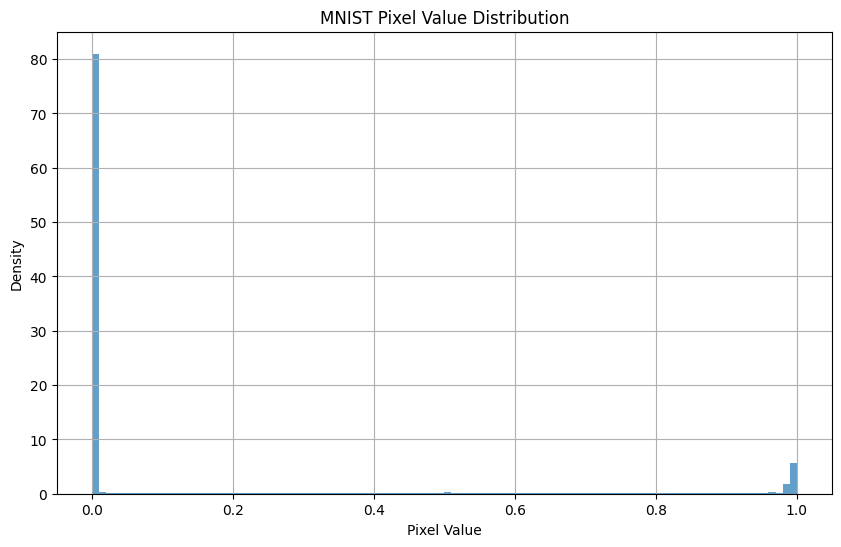

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def analyze_distribution_and_losses(loader_test, loader_train, device):
    """
    Analyze MNIST data distribution and compare different reconstruction losses.
    """
    # Get batch of test data for loss comparison
    x, _ = next(iter(loader_test))
    x = x.to(device)[0:32, :, :, :]
    
    # Create mock reconstructions (slightly perturbed versions of input)
    # This simulates what a trained VAE might produce
    recon_x = x + 0.1 * torch.randn_like(x)
    recon_x = torch.clamp(recon_x, 0, 1)
    
    # Flatten inputs for loss calculations
    x_flat = x.view(-1)
    recon_x_flat = recon_x.view(-1)
    
    # 1. Gaussian Distribution Losses
    # Log probability under Gaussian assumption
    var = 0.1  # assumed variance
    log_scale = math.log(math.sqrt(2 * math.pi * var))
    loss1 = -0.5 * torch.sum((x_flat - recon_x_flat)**2 / var) - x_flat.numel() * log_scale
    
    # Mean Squared Error
    loss2 = F.mse_loss(recon_x_flat, x_flat, reduction='sum')
    
    # MSE with constant terms to match Gaussian log prob
    loss3 = loss2 / (2 * var) + x_flat.numel() * log_scale
    
    # 2. Bernoulli Distribution Losses
    # Binary Cross Entropy
    loss4 = F.binary_cross_entropy(recon_x_flat, x_flat, reduction='sum')
    
    # Bernoulli log probability (same as BCE for binary data)
    loss5 = loss4
    
    # 3. Plot histogram of all training data
    all_train_dataloader = DataLoader(train_dat, batch_size=len(train_dat))
    data = next(iter(all_train_dataloader))[0]
    data_flat = data.flatten().numpy()
    
    plt.figure(figsize=(10, 6))
    plt.hist(data_flat, bins=100, density=True, alpha=0.7)
    plt.grid(True)
    plt.title('MNIST Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Density')
    
    # Print loss comparisons
    print('Gaussian Distribution Losses:')
    print(f'Gaussian log probability: {loss1:.3f}')
    print(f'Mean Squared Error: {loss2:.3f}')
    print(f'MSE + constant terms: {loss3:.3f}\n')
    
    print('Bernoulli Distribution Losses:')
    print(f'Binary Cross Entropy: {loss4:.3f}')
    print(f'Bernoulli log probability: {loss5:.3f}')
    
    return loss1, loss2, loss3, loss4, loss5

# Example usage:

losses = analyze_distribution_and_losses(loader_test, loader_train, device)


<!-- BEGIN QUESTION -->



In [ ]:
# Any code for your explanation here

import math
import matplotlib.pyplot as plt

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################
        
# Set-up
x, _ = next(iter(loader_test))
x = x.to(device)[0:32, :, :, :]

...

print('Gaussian distribution')
print(f'Normal log prob:                 {loss1:.3f}')
print(f'MSE:                             {loss2:.3f}')
print(f'MSE + constant terms = log prob: {loss3:.3f}')
print()
print('Multinulli distribution')
print(f'Cross entropy:              {loss4:.3f}')
print('Bernoulli distribution')
print(f'Bernoulli log prob:              {loss4:.3f}')
print(f'BCE:                             {loss5:.3f}')

all_train_dataloader = DataLoader(train_dat, len(train_dat))
data = next(iter(all_train_dataloader))
data = data[0].flatten().numpy()
plt.hist(data, bins=100)
plt.grid()
plt.title('Histogram of the training data\nshowing nearly binomial distribution')

#######################################################################
#                       ** END OF YOUR CODE **
####################################################################### 

<!-- END QUESTION -->

## Part 1.2 - Evaluation (10 points)

a. Plot your loss curves

b. Show reconstructions and samples

### Part 1.2a - Loss Curves (3 Points)
Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). If you experimented with different values of $\beta$, you may wish to display multiple plots (worth 1 point).

<!-- BEGIN QUESTION -->



In [ ]:
# *CODE FOR PART 1.2a IN THIS CELL*
#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
train_losses_ = ...
test_losses_ = ...

train_l = ...
test_l = ...
labels = ['total', 'NLL', 'KL']
...
ax.grid()
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss curves for beta = 5, latent vectors = 20')
#######################################################################
#                       ** END OF YOUR CODE **
####################################################################### 

<!-- END QUESTION -->

### Part 1.2b - Samples and Reconstructions (7 Points)
Visualize a subset of the images of the test set and their reconstructions **as well as** a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation). (4 points)

For reference, here's [some samples from our VAE](https://imgur.com/NwNMuG3).


<!-- BEGIN QUESTION -->



In [ ]:
# *CODE FOR PART 1.2b IN THIS CELL*

# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
model.eval()
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    ...
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                             scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')  
print('-'*50)
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    ...
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                             scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)

### Discussion
Provide a brief analysis of your loss curves and reconstructions: 
* What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)?
* Can you intuitively explain if this behaviour is desirable? 
* What is posterior collapse and did you observe it during training (i.e. when the KL is too small during the early stages of training)? 
    * If yes, how did you mitigate it? How did this phenomenon reflect on your output samples?
    * If no, why do you think that is?

### Your Answer (3 points)

_Type your answer here, replacing this text._

<!-- END QUESTION -->


## Part 1.3 - Latent Space Exploration (10 points)

In this question you are asked to qualitatively assess the learned representations that your model has learned. In particular:

a. Dimensionality Reduction of learned embeddings

b. Interpolating in the latent space

### Part 1.3a - T-SNE on Embeddings (5 Points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)  [(see implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). You can use a T-SNE implementation from a library such as scikit-learn. 

You are encouraged to also produce a matplotlib plot (please use different colours for each digit class) with different (max 4) perplexity values (e.g. 3, 30, 50).

<!-- BEGIN QUESTION -->



In [ ]:
# *CODE FOR PART 1.3a IN THIS CELL
#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################
from sklearn.manifold import TSNE

#! You can vary the size of the test set for quick debugging. We recommend 1000 to 10000 to final tests
test_dataloader = DataLoader(test_dat, 100, shuffle=False)

# Get latent dimensions for test set
...
# Perform TSNE
print('Performing TSNE')
z_embedded_5 = ...
z_embedded_30 = ...
z_embedded_50 = ...
#######################################################################
#                       ** END OF YOUR CODE **
####################################################################### 

<!-- END QUESTION -->



In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(19.2, 4.8))
labels = [5, 30, 50]
z_list = [z_embedded_5, z_embedded_30, z_embedded_50]
for i in range(len(labels)):
    for digit in np.unique(y):
        idx = np.where(y == digit)
        ax[i].scatter(z_list[i][idx,0], z_list[i][idx,1], label=digit)
    ax[i].legend()
    ax[i].set_title(f'TSNE plot for beta = 5, latent vectors = 20, perplexity = {labels[i]}')

### Part 1.3b - Interpolating in $z$ (5 Points)

Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?


<!-- BEGIN QUESTION -->



In [ ]:
# CODE FOR PART 1.3b IN THIS CELL
#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################
num_steps = 10
...
image1 = ...
image2 = ...
...
interpolated_embeddings = ...

with torch.no_grad():
    interpolated_images = ...

def imshow(img, ax):
    img = img.permute(1, 2, 0)
    ax.imshow(img.cpu().numpy())
    ax.axis('off')

fig, axes = plt.subplots(1, interpolated_images.size(0) + 2, figsize=(20, 5))
imshow(image1[0], axes[0])
axes[0].set_title('Original Image 1')
for i in range(interpolated_images.size(0)):
    imshow(interpolated_images[i], axes[i + 1])
axes[1].set_title('Interpolated Images')
imshow(image2[0], axes[-1])
axes[-1].set_title('Original Image 2')
plt.show()
#######################################################################
#                       ** END OF YOUR CODE **
####################################################################### 

<!-- END QUESTION -->

 ## Part 1.4 - Hot Dog Generation (10 points)

 Now we'll apply our VAE to the more challenging task of generating hot dog images. This requires adapting our model to handle:

 - RGB images (3 channels instead of 1)

 - More complex visual features

 - Higher resolution inputs


In [ ]:
# %%
# Now let's adapt our VAE for hot dog image generation
# The DLHotDogDataset class will automatically download and prepare the dataset
# Since our VAE architecture is relatively simple, we'll start with the same 
# resolution as MNIST (28x28) to establish a baseline
# Note this can take a while to load

# Define image parameters
image_size = 28  # Same size as MNIST for initial experiments
batch_size = 64  # Process 64 images at a time

# Define training data transforms
# - ToTensor: Convert PIL images to tensors and scale to [0,1]
# - Normalize: Rescale to [-1,1] using mean=(0.5,0.5,0.5) and std=(0.5,0.5,0.5)
# - Resize: Scale images to 28x28
# - Random flips: Data augmentation to help prevent overfitting
transform_ = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((image_size, image_size)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5)]
     )

# Define test data transforms - same as training but without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_size, image_size))
])

# Create train and test datasets
hotdogdata_train = DLHotDogDataset(root=data_path, transform=transform_, split='train')
hotdogdata_test = DLHotDogDataset(root=data_path, transform=transform_test, split='test')

# Create data loaders for batched processing
# Shuffle training data but keep test data ordered
hotdogdata_loader_train = DataLoader(hotdogdata_train, batch_size, shuffle=True)
hotdogdata_loader_test = DataLoader(hotdogdata_test, batch_size, shuffle=False)

# Save a batch of original test images for later comparison
# Takes first 32 images from test set
sample_inputs_, _ = next(iter(hotdogdata_loader_test))
fixed_input_ = sample_inputs_[:32, :, :, :]
save_image(fixed_input_, content_path/'CW_VAE/image_original_hd.png')

 #### Part 1.4a - Train the VAE (4 points)



 * here you will need to assume a normal distribution for your loss function unlike above

 * the data also has 3 channels now instead of only one

 * otherwise the VAE can be trained in the same way as for MNIST above

 * training will take 60 min for this dataset for 30 epochs (more samples) but results will be limited as shown in Fig 3. (except if your VAE is brilliant ;) ).





<!-- BEGIN QUESTION -->



In [ ]:
# %%
#We need a bit more training as for MNIST but don't expect much
num_epochs = 60

def loss_function_VAE(recon_x, x, mu, logvar, beta):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################  
        # Assume Normal distribution
        ...
        return NLL + KLD, NLL, KLD

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

model = VAE(3, latent_dim).to(device)
model_path = f"./VAE_hd_model_{latent_dim}.pth"

 #optional -- do this if you want to continue training on a previous training run
load_checkpoint = False
if os.path.exists(model_path) and load_checkpoint:
    print("loading existing model...")
    model.load_state_dict(torch.load(model_path))
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
test_losses = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = lr_step_size, gamma = lr_gamma)
for epoch in range(num_epochs):     
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        ...
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        # save the model
        if epoch % 5 == 0:
            with torch.no_grad():
                torch.save(model.state_dict(), model_path)
                
        if epoch == num_epochs - 1:
            with torch.no_grad():
                torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                    'VAE_hd_model_jit.pth')


<!-- END QUESTION -->

 #### Part 1.4b - Sample Visualisation (3 points)



 <img src="https://www.doc.ic.ac.uk/~bkainz/teaching/DL/bad_VAE.png" alt="Hot-dog Generator Model" width="100">



 *Figure 3: do not expect samples getting much better than this.*

<!-- BEGIN QUESTION -->



In [ ]:
# %%
# *CODE FOR PART 1.2b IN THIS CELL*

# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(hotdogdata_loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
model.eval()
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    ...
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')  
print('-'*50)
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    ...
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)


<!-- END QUESTION -->

 #### Part 1.4c - Interpolating in $z$ (3 points)



 Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

<!-- BEGIN QUESTION -->



In [ ]:
# %%
# CODE FOR PART 1.3b IN THIS CELL
#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################
num_steps = 10
...
image1 = ...
image2 = ...
...
interpolated_embeddings = ...

with torch.no_grad():
    interpolated_images = ...


def imshow(img, ax):
    img = img.permute(1, 2, 0)
    ax.imshow(img.cpu().numpy())
    ax.axis('off')

fig, axes = plt.subplots(1, interpolated_images.size(0) + 2, figsize=(20, 5))
imshow(image1[0], axes[0])
axes[0].set_title('Original Image 1')
for i in range(interpolated_images.size(0)):
    imshow(interpolated_images[i], axes[i + 1])
axes[1].set_title('Interpolated Images')
imshow(image2[0], axes[-1])
axes[-1].set_title('Original Image 2')
plt.show()
#######################################################################
#                       ** END OF YOUR CODE **
####################################################################### 


<!-- END QUESTION -->

 <h3> oh boy, this looks terribe... </h3>



 let's use a more powerful pretrained VAE in Part 2.

----

# Part 2 - Denoising Diffusion Probabilistic Model (DDPM) (50 Points)

Since the VAE above is undertrained to represent hot dogs well, we try to use one of the most powerful representation embeddings to date, the VAE of Stable Diffusion. This we can get from HuggingFace. If the provided token does not work, get a huggingface.com account and generate your own access token. This is required to download the model. 

In [63]:
import os 
# We specified data path in part 1
cache_path = os.path.join(data_path, "cache")
print('Caching models in', cache_path)
%env XDG_CACHE_HOME=cache_path
%env HF_HOME=cache_path

import torch 
from PIL import Image
from torchvision import transforms
from diffusers import AutoencoderKL
import matplotlib.pyplot as plt 
from torch.optim import Adam
from typing import Dict, Tuple
from tqdm import tqdm

from torchvision import transforms
import numpy as np
from typing import Any, Callable, Optional, Tuple, Union
from pathlib import Path

Caching models in /vol/bitbucket/ad524/DL_CW_2_ad524/data/cache
env: XDG_CACHE_HOME=cache_path
env: HF_HOME=cache_path


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

<h2> Loading a pretrained VAE from HuggingFace </h2>
 Let's do what many generative AI researchers do right now and connect to HuggingFace's transformer library and model zoo.
 This will give us access to powerful pretrained models like Stable Diffusion's VAE.

 To access the pretrained models from HuggingFace, we need a write access token.
 This token acts like a password that gives us permission to download models from HuggingFace's model hub.
 
 When you run the cell below, you'll be prompted to login to HuggingFace if you don't have a token.
 After logging in, make sure to select "Write" access when generating your token, as shown in the screenshot.
 The write access token will allow us to not only read but also potentially contribute models back to the community.
 
 <img src="https://www.doc.ic.ac.uk/~afs219/hf_token_example.png" width="450"/>

In [ ]:
from huggingface_hub import login, HfFolder

# Get token from environment variable or prompt user to login
manual_token = "dl_cw2" #"<your-huggingface-token>"
if manual_token is None:
    token = HfFolder.get_token()
    if token is None:
        print("Please login to Hugging Face to get a token")
        login(add_to_git_credential=True)
else:
    token = manual_token
    login(token=token, add_to_git_credential=True)

The following provides a simple wrapper for Stable Diffusion's extensively trained VAE

In [66]:
#a wrapper for Stable Diffusion's VAEs 
class VAE: 
    def __init__(self, device="cuda") -> None:
        vae = AutoencoderKL.from_pretrained(
            "stabilityai/stable-diffusion-2-base", subfolder="vae",
        )

        vae = vae.to(device)
        self.vae = vae

    def __call__(self, x):
        # assumes 0-1 normalized image
        single_image = False
        if len(x.size()) == 3: 
            single_image = True
            x = x.unsqueeze(dim=0)
        
        if x.min() >= 0: 
            x = x * 2 - 1 

        with torch.no_grad():
            encode = self.vae.encode(x.cuda())
            batch = encode.latent_dist.sample() *  self.vae.config.scaling_factor
        if single_image: 
            batch = batch.squeeze(dim=0)
        return batch

    def encode(self, x): 
        return self(x)
    
    def decode(self, z): 
        """
        returns: decode image"""
        if len(z.size()) == 3: 
            z = z.unsqueeze(dim=0)
        with torch.no_grad():
            x = self.vae.decode(z / self.vae.config.scaling_factor, return_dict=False)[0]
            #x = self.vae.decode(z , return_dict=False)[0]

        x = ((1 + x) * 0.5).clip(0, 1)
        return x

sd_vae = VAE()


vae%2Fconfig.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

 ## Part 2.1 - Exploring the Stable Diffusion VAE (3 points)
 
 Now that we have access to a pretrained VAE from Stable Diffusion, let's explore its capabilities and compare its performance to our trained VAE from Part 1. We'll perform similar experiments to analyze the quality and characteristics of its latent space:

 1. Linear interpolation between embeddings to examine the smoothness and meaningfulness of the latent space transitions
 2. Random sampling from the latent space to assess the quality of the generated images and understand what the VAE has learned

 This comparison will help us understand how a production-grade VAE performs compared to our simpler implementation which was trained on a small dataset.


In [67]:
# Configure autoreload to automatically reload modules when they change
%load_ext autoreload
%autoreload 2

# Import required libraries for dataset handling
from icl_dl_cw2_utils.utils.hotdogdataset import DLHotDogDataset
from torch.utils.data import DataLoader

# Define image size and batch size parameters
# Using larger images since we don't need to train the VAE anymore
image_size_ = 112  # Target image size after transforms
batch_size = 32    # Number of images per batch

# Define image transformations for training data
# First resize to 128 then center crop to ensure consistent sizing
transform_ = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(image_size_),
    transforms.ToTensor()
])

# Define image transformations for test data
transform_test_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_size_, image_size_))
])

# Load training and test datasets with the defined transforms
hotdogdata_train_256 = DLHotDogDataset(root=data_path, transform=transform_, split='train', preload=True)
hotdogdata_test_256 = DLHotDogDataset(root=data_path, transform=transform_, split='test', preload=True)

# Create data loaders for efficient batching
# num_workers=8 enables parallel data loading
hotdogdata_loader_train_112 = DataLoader(hotdogdata_train_256, batch_size, shuffle=True, num_workers=8)
hotdogdata_loader_test_112 = DataLoader(hotdogdata_test_256, batch_size, shuffle=True, num_workers=8)

# Get a batch of test images to verify dimensions
data_iter = iter(hotdogdata_loader_test_112)
images, _ = next(data_iter)
print(f"Batch shape: {images.shape} (batch_size, channels, height, width)")

# Calculate and display dataset statistics
hotdogdata_mean, hotdogdata_std_dev = hotdogdata_train_256.calculate_mean_and_std()
print(f'Dataset statistics:')
print(f'Mean pixel value: {hotdogdata_mean:.4f}')
print(f'Standard deviation: {hotdogdata_std_dev:.4f}')


52656it [00:01, 38409.76it/s]
1it [00:00, 9489.38it/s]


KeyboardInterrupt: 

### Part 2.1a - Interpolating in $z$ (1 point)

Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

<!-- BEGIN QUESTION -->



In [ ]:
# CODE FOR PART 2.1a - Linear Interpolation in Latent Space
# This code demonstrates how to:
# 1. Take two images from the dataset
# 2. Encode them into the latent space
# 3. Create interpolated points between their latent representations
# 4. Decode the interpolated points back to images

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

# Number of interpolation steps between the two images
num_steps = 10

# Get a batch of training images
data_iter = iter(hotdogdata_loader_train_112)
images, _ = ...
print(f"Loaded batch of images with shape: {images.shape}")

# Select first two images and move to device
image1 = ...
image2 = ...
print(f"Individual image shape: {image1.shape}")

...
# Create interpolated points in latent space
interpolated_embeddings = ...
print(f"Shape of interpolated embeddings: {interpolated_embeddings.shape}")         

# Decode interpolated points back to images
with torch.no_grad():
    interpolated_images = ...
    print(f"Shape of decoded interpolated images: {interpolated_images.shape}")

def imshow(img, ax):
    """Display an image on the given matplotlib axis"""
    img = img.squeeze().permute(1, 2, 0)
    ax.imshow(img.cpu().numpy())
    ax.axis('off')

# Create visualization of original images and interpolations
fig, axes = plt.subplots(1, interpolated_images.size(0) + 2, figsize=(20, 5))

# Show first original image
imshow(image1, axes[0])
axes[0].set_title('Original Image 1')

# Show interpolated images
for i in range(interpolated_images.size(0)):
    imshow(interpolated_images[i], axes[i + 1])
    axes[i + 1].set_title(f'{i*10}% of Image 2')

# Show second original image
imshow(image2, axes[-1])
axes[-1].set_title('Original Image 2')

plt.suptitle('Linear Interpolation Between Two Images in Latent Space', y=0.75)
plt.tight_layout()
plt.show()

#######################################################################
#                       ** END OF YOUR CODE **
####################################################################### 


<!-- END QUESTION -->

### Part 2.1b - Sample visualisation (2 points)
visualisation (1 point), written answer (1 point)

<!-- BEGIN QUESTION -->



In [ ]:
# CODE FOR PART 2.1b - Visualization of VAE Results
# This section demonstrates reconstruction and generation capabilities of the trained VAE

from torchvision.utils import save_image, make_grid

# Helper function to denormalize images if needed
def denorm(x):
    return x

# 1. Visualize Input Images
print('\n1. Displaying Original Input Images from Test Set')
print('-'*70)
sample_inputs, _ = next(iter(hotdogdata_loader_test_112))
fixed_input = sample_inputs[0:32, :, :, :]
input_grid = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                      scale_each=False, pad_value=0)
plt.figure()
plt.title('Original Test Set Images')
show(input_grid)

# 2. Visualize Reconstructed Images
print('\n2. Displaying VAE Reconstructions')
print('-'*70)
print('The VAE should learn to accurately reconstruct the input images')

with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    # CODE: Implement the reconstruction process:
    # 1. Move input images to device
    # 2. Encode images to get latent embeddings
    # 3. Decode latent embeddings back to images
    #######################################################################
    ...
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################
    
    recon_grid = make_grid(denorm(recon_batch.cpu()), nrow=8, padding=2, normalize=False,
                          scale_each=False, pad_value=0)
    plt.figure()
    plt.title('VAE Reconstructed Images')
    show(recon_grid)

# 3. Generate New Images from Random Noise
print('\n3. Displaying Generated Images from Random Noise')
print('-'*70)
print('The VAE should generate plausible new images from random latent vectors')

n_samples = 256
print(f'Latent embedding shape: {recon_emb.shape}')
z = torch.randn_like(recon_emb).to(device)

with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    # CODE: Implement the generation process:
    # 1. Sample random noise vectors from normal distribution
    # 2. Decode noise vectors to generate new images
    #######################################################################
    ...
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################
    
    samples_grid = make_grid(denorm(samples.cpu()), nrow=16, padding=2, normalize=False,
                           scale_each=False, pad_value=0)
    plt.figure(figsize=(8,8))
    plt.title('VAE Generated Images from Random Noise')
    show(samples_grid)

### Question 

The quality of random samples from the VAE's latent space are poor despite using a well-trained VAE. Please detail why this is the case and why moving to latent diffusion models provides an effective solution. In your answer, discuss the limitations of random sampling and explain how latent diffusion models address these challenges.


### Your Answer (1 point)

_Type your answer here, replacing this text._

<!-- END QUESTION -->

## Part 2.2 - Implementing a Latent Diffusion Model (32 points)

 Whilst we provide some details below, for an excellent high-level overview of diffusion models, we highly recommend reading Lilian Weng's blog post:
 https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

 However, you will still need to carefully study the mathematical details in the original DDPM paper 
 (https://arxiv.org/abs/2006.11239) to implement the model correctly. We'll first build the pre-computed 
 schedules for the DDPM, then implement the noise predictor model, and finally the DDPM itself. While the DDPM 
 can be used on images directly or on embedding latent codes (as we can generate with our Stable Diffusion VAE), 
 we'll focus on latent diffusion since the latent codes are much smaller and training is significantly faster. 
 This is also practical since we don't have the compute power to use DDPM directly on our 112x112 hot dog images.



### Background 



 Diffusion models learn to gradually denoise data by reversing a fixed forward diffusion process. The process works in two phases:



 #### Forward Diffusion 

 We define a forward process that gradually adds Gaussian noise to an image x₀ over T timesteps:



 $q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t\mathbf{I})$



 where βₜ is a variance schedule that controls the noise level. This can be written in closed form:



 $q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t)\mathbf{I})$



 where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$



 #### Reverse Diffusion 

 We train a model to reverse this process by predicting the noise at each step:



 $p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t,t), \sigma_t^2\mathbf{I})$



 The mean is predicted by our noise prediction model:



 $\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t,t))$



 #### Training Objective 

 We train the model to predict the noise ε added during the forward process:



 $\mathcal{L} = \mathbb{E}_{t,x_0,\epsilon}[\|\epsilon - \epsilon_\theta(x_t,t)\|_2^2]$



 where:

 - t is sampled uniformly from [1,T]

 - x₀ is sampled from the training data

 - ε is sampled from N(0,I)

 - xₜ is computed using the reparameterization trick


 #### Latent Diffusion 

 Rather than operating directly on pixels, we'll apply diffusion in the latent space of a pre-trained VAE:

 1. Encode images to latent space using VAE encoder

 2. Apply diffusion process to latent vectors

 3. Decode generated latents to images



 This significantly reduces computational cost while maintaining generation quality.


### Part 2.2a - Implement Pre-Computed DDPM Schedules (5 points)

The DDPM process requires several pre-computed schedules that control how noise is added and removed during training and sampling. These schedules are carefully designed to:

1. Gradually corrupt the data with noise in a controlled way during the forward process
2. Allow the model to learn to denoise effectively during training  
3. Enable high-quality sample generation during the reverse process

The key schedules are:

Linear noise schedule $\beta_t$ that increases from $\beta_1$ to $\beta_2$:

$\beta_t = \beta_1 + (\beta_2 - \beta_1)\frac{t}{T}$

This schedule starts with small noise ($\beta_1$) and gradually increases to larger noise ($\beta_2$), allowing for:
- Initial steps that preserve more image structure
- Later steps that add more randomness

Alpha values derived from betas:
$\alpha_t = 1 - \beta_t$

Cumulative product of alphas:
$\bar{\alpha}_t = \prod_{i=1}^t (1 - \beta_i)$

Other important quantities and their purposes:
- $\frac{1}{\sqrt{\alpha_t}}$: Used in mean calculation to properly scale the denoising prediction
- $\sqrt{\beta_t}$: Controls the standard deviation of noise added at each step  
- $\sqrt{\bar{\alpha}_t}$: Coefficient for $x_0$ term - determines how much original signal remains
- $\sqrt{1-\bar{\alpha}_t}$: Coefficient for noise term - determines how much noise has accumulated

These values enable us to:
1. Sample from the forward process (adding noise):
$q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t)\mathbf{I})$

2. Sample from the reverse process (removing noise):
$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t,t), \sigma_t^2\mathbf{I})$

The careful balancing of these schedules is crucial for stable training and high-quality generation.

<!-- BEGIN QUESTION -->



In [ ]:
# CODE FOR PART 2.2a IN THIS CELL

def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """
    Returns pre-computed schedules for DDPM sampling and training process.
    
    Args:
        beta1: Starting value of noise schedule (must be between 0 and 1)
        beta2: Ending value of noise schedule (must be between beta1 and 1)
        T: Number of timesteps in the diffusion process
        
    Returns:
        Dict containing the following tensors of shape (T+1,):
            alpha_t: The alpha schedule values
            oneover_sqrta: 1/sqrt(alpha_t) for scaling in diffusion process
            sqrt_beta_t: sqrt(beta_t) for noise scaling
            alphabar_t: The cumulative product of (1-beta) 
            sqrtab: sqrt(alphabar_t) for x0 coefficient
            sqrtmab: sqrt(1-alphabar_t) for epsilon coefficient
            mab_over_sqrtmab: (1-alpha_t)/sqrt(1-alphabar_t) for posterior variance
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    ...
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

In [ ]:
grader.check("Q2.2a DDPM Schedule")

<!-- END QUESTION -->



In [ ]:
def plot_ddpm_schedules(beta1: float, beta2: float, T: int):
    """
    Plots the DDPM schedules to visualize how they change over timesteps.
    
    Args:
        beta1: Starting value of noise schedule
        beta2: Ending value of noise schedule  
        T: Number of timesteps
    """
    schedules = ddpm_schedules(beta1, beta2, T)
    
    explanations = {
        "alpha_t": "Complement of noise level (1-β)\nControls signal preservation",
        "oneover_sqrta": "Scaling factor 1/√α\nUsed in denoising prediction",
        "sqrt_beta_t": "√β: Standard deviation\nof noise added per step",
        "alphabar_t": "ᾱ: Cumulative product of (1-β)\nTotal signal remaining",
        "sqrtab": "√ᾱ: Coefficient for x₀\nScales original image",
        "sqrtmab": "√(1-ᾱ): Coefficient for ε\nScales noise component",
        "mab_over_sqrtmab": "(1-α)/√(1-ᾱ)\nPosterior variance scaling"
    }
    
    plt.figure(figsize=(15, 10))
    
    # Plot each schedule on separate subplots
    for idx, (name, values) in enumerate(schedules.items(), 1):
        plt.subplot(3, 3, idx)
        plt.plot(values.numpy())
        plt.title(f"{name}\n{explanations[name]}", fontsize=10)
        plt.xlabel('Timestep')
        plt.ylabel('Value')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_ddpm_schedules(0.0001, 0.02, 1000)

 ### Part 2.2b - Noise Predictor Model (10 points)

 The noise predictor model is a crucial component of the diffusion process that learns to predict and remove noise from images. It takes a noisy image and timestep as input and predicts the noise that was added, enabling the gradual denoising process.

 Define a $R_n \rightarrow R_n$ noise predictor model with the following options:

 1. Simple CNN Approach (6 points):
    * A basic multi-layer CNN that maps noisy images to predicted noise
    * Simpler architecture but can still be effective for denoising
    * Example structure: Multiple conv layers with increasing then decreasing channels

 2. U-Net Approach (+2 points):
    * More sophisticated architecture commonly used in diffusion models
    * Includes skip connections to preserve spatial information
    * Better at capturing both local and global image features

 3. Positional Encoding (+2 points):
    * Add timestep embeddings to help the model understand the noise level
    * Can be implemented as sinusoidal embeddings or learned embeddings
    * Critical for conditioning the model on different timesteps

 Requirements:
 * The model MUST NOT exceed 20M parameters
 * Implementing both architectures (CNN and UNet) will not yield additional points
 * Choose one approach and implement it well



_Type your answer here, replacing this text._

<!-- BEGIN QUESTION -->



In [ ]:
# CODE FOR PART 2.2b simple CNN IN THIS CELL (or use cell below for UNet with or without positional encoding)

from torchvision.utils import save_image, make_grid
import torch.nn as nn

block = lambda ic, oc: nn.Sequential(
    nn.Conv2d(ic, oc, 7, padding=3),
    nn.BatchNorm2d(oc),
    nn.LeakyReLU(),
)

class SimpleEpsModel(nn.Module):
    """
    Basically, any universal R^n -> R^n model should work for denoising, so try some very simple CNN.
    """

    def __init__(self, n_channel: int) -> None:
        super(SimpleEpsModel, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        ...
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x, t) -> torch.Tensor:
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # In the paper, they used Tr-like positional embeddings but t is not absolutly necessary, depending on your model.
        ...
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
    
eps_model = SimpleEpsModel(4)
print("Num params: ", sum(p.numel() for p in eps_model.parameters()))

In [ ]:
import torch
import torch.nn as nn
import math

class Block(nn.Module):
    """
    A basic building block for the U-Net architecture that processes both spatial and temporal information.
    
    Args:
        in_ch (int): Number of input channels
        out_ch (int): Number of output channels 
        time_emb_dim (int): Dimension of time embedding
        up (bool): If True, uses transposed convolution for upsampling. If False, uses regular convolution for downsampling
    """
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        ...
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x, t):
        """
        Forward pass of the block.
        
        Args:
            x (torch.Tensor): Input feature maps
            t (torch.Tensor): Time embeddings
            
        Returns:
            torch.Tensor: Transformed feature maps
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        
        # First Conv + Norm + Activation
        h = ...
        
        # Process time embeddings
        time_emb = ...
        # Add two dummy spatial dimensions to match feature map
        time_emb = ...
        # Add time information to features
        h = ...
        
        # Second Conv + Norm + Activation
        h = ...
        # Final transformation (up/downsampling)
        ...
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

class SinusoidalPositionEmbeddings(nn.Module):
    """
    Creates sinusoidal positional embeddings for time steps.
    Uses alternating sine and cosine functions at different frequencies.
    
    Args:
        dim (int): Dimension of the embeddings
    """
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    
    def __init__(self, dim):
        ...
    
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    def forward(self, time):
        """
        Compute positional embeddings for given timesteps.
        
        Args:
            time (torch.Tensor): Tensor of timesteps
            
        Returns:
            torch.Tensor: Position embeddings of shape (batch_size, dim)
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        ...
        embeddings = ...
        
        return embeddings
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture for diffusion models.
    Includes time conditioning and skip connections.
    
    Args:
        in_channels (int): Number of input image channels
    """
    def __init__(self, in_channels=4):
        super().__init__()
        image_channels = in_channels
        down_channels = (128, 256, 512)  # Limited the downsampling stages
        up_channels = (512, 256, 128)
        out_dim = in_channels
        time_emb_dim = 256

        # Time embedding layers
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # Initial projection of image
        self.conv0 = ...

        # Downsampling path
        self.downs = ...
        # Bottleneck block
        self.bottleneck = ...

        # Upsampling path
        self.ups = ...

        # Final projection to output channels
        self.output = ...

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x, timestep):
        """
        Forward pass of the U-Net.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width)
            timestep (torch.Tensor): Current timestep for conditioning
            
        Returns:
            torch.Tensor: Output tensor of same shape as input
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Get time embeddings
        t = ...
        
        # Initial convolution
        x = ...
        
        # Store intermediate outputs for skip connections
        residual_inputs = []
        # Downsampling path
        ...
        # Bottleneck
        x = ...
        
        # Upsampling path with skip connections
        ...
        ...
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

# Test the model, your latent input shape will only be [4,14,14], which means that kernel sizes can quickly get larger than input sizes
input_tensor = torch.randn(1, 4, 14, 14)
timestep = torch.tensor([1.0])
UNetModel = SimpleUnet()
output = UNetModel(input_tensor, timestep)
print("Output shape:", output.shape)
print("Num params: ", sum(p.numel() for p in UNetModel.parameters()))


<!-- END QUESTION -->

### Part 2.2c - Defition of the DDPM (10 points)

Now we define the DDPM. Remember that the noise predictor model's task is only to predict the amount of noise between time step $T$ and $T+n$.

<!-- BEGIN QUESTION -->



In [ ]:
# CODE FOR PART 2.2c IN THIS CELL 

import torch
import torch.distributions as dist

class DDPM(nn.Module):
    """
    Denoising Diffusion Probabilistic Model (DDPM) implementation.
    
    This class implements the DDPM as described in "Denoising Diffusion Probabilistic Models" 
    (Ho et al., 2020). The model learns to reverse a gradual noising process.
    
    Args:
        eps_model (nn.Module): The neural network that predicts noise at each timestep
        betas (Tuple[float, float]): Beta schedule parameters (β_start, β_end)
        n_T (int): Number of timesteps in the diffusion process
        criterion (nn.Module): Loss function for training, defaults to MSELoss
    """
    def __init__(
        self,
        eps_model: nn.Module,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss()
    ) -> None:
        super(DDPM, self).__init__()
        self.eps_model = eps_model

        # register_buffer allows us to freely access these tensors by name. It helps device placement.
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.criterion = criterion

        # Initialize with dataset statistics for potentially better starting point
        mean =  0.04640255868434906
        std_dev = 0.8382343649864197
        self.normal_dist = dist.Normal(mean, std_dev)
        

    def forward(self, x: torch.Tensor, t: torch.Tensor = None) -> torch.Tensor:
        """
        Performs forward diffusion and predicts the noise added at timestep t.
        
        This implements Algorithm 1 from the DDPM paper:
        1. Sample a random timestep t
        2. Sample random noise ε
        3. Create noised input x_t using the noise schedule
        4. Predict the noise using the model
        5. Return the loss between predicted and actual noise
        
        Args:
            x (torch.Tensor): Input images/data
            t (torch.Tensor, optional): Specific timestep. If None, randomly sampled.
            
        Returns:
            Tuple containing:
            - Loss between predicted and actual noise
            - The sampled noise (eps)
            - The noised input at timestep t (x_t)
        """
        #######################################################################
        #                       ** START OF YOUR CODE **
        ####################################################################### 
        # Step 1: Sample timestep t if not provided
        ...
        # Step 2: Sample noise from normal distribution
        ...
        # Step 3: Create noised input x_t using the forward process
        # x_t = √(αbar_t) * x_0 + √(1-αbar_t) * ε
        ...
        # Step 4 & 5: Predict noise using eps_model and return loss
        # Note: timesteps are normalized to [0,1] range for the model
        ...
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def sample(self, n_sample: int, size, device, t = 0) -> torch.Tensor:
        """
        Samples new images using the trained diffusion model.
        
        Implements Algorithm 2 from the DDPM paper - the reverse diffusion process.
        Starting from pure noise, gradually denoise to generate new samples.
        
        Args:
            n_sample (int): Number of samples to generate
            size (tuple): Size of each sample
            device: Device to generate samples on
            t (int): Starting timestep (default=0)
            
        Returns:
            torch.Tensor: Generated samples
        """
        # Start from pure noise
        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)
        
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Gradually denoise the samples
        for i in range(self.n_T, t, -1):
            ...
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return x_i

<!-- END QUESTION -->

### Part 2.2d - Forward Diffusion Visualisation (7 points)

Let's try if the forward process works. Provide 10 samples of a randomly chosen hot-dog between time steps T = 0 (min) to T = 1000 (max), encode it, gradually noise the latent code with your forward model and decode it again. 
Hint: no training is required for this step.

<img src="https://www.doc.ic.ac.uk/~bkainz/teaching/DL/example_noise.png" alt="Hot-dog Generator Model" width="700">

*Figure 4: here is an example how this could look like.* 



<!-- BEGIN QUESTION -->



In [ ]:
# CODE FOR PART 2.2d IN THIS CELL 

import torch.distributions as dist

# Helper function to display tensor images
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.ToPILImage(),
    ])
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

# Set up DDPM model parameters
print("Setting up DDPM model with 1000 timesteps...")
T = 1000

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

ddpm = ...

# Get a sample image and encode it to latent space
print("\nStep 1: Loading and encoding a sample hot dog image")
image = next(iter(hotdogdata_loader_test_112))[0]
print(f"Original image shape: {image.shape}")

image = image.to(device)

emb = ...

latent_shape = emb.shape
print(f"Encoded latent shape: {emb.shape}")

# Visualize forward diffusion process
print("\nStep 2: Visualizing forward diffusion process over time")
print("Creating plot with 10 timesteps from t=0 to t=T...")
plt.figure(figsize=(20,2))  
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

# Apply noise gradually and show results
print("\nStep 3: Applying noise gradually and decoding at each step...")
for idx in range(0, T, stepsize):
    ...
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    plt.axis('off')
    ...
    img = ...
    show_tensor_image(img)
plt.tight_layout()  # Adjust spacing between subplots
print("\nVisualization complete - observe how the image becomes increasingly noisy over time")

#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################  


<!-- END QUESTION -->

<h3> Hotdog or not? </h3>

We provide a ready made food classifier for evaluation. The hot dog category is 55 in the classifier's output.
This classifier is a ResNet model trained on a large food image dataset with 101 categories.
It outputs a probability distribution over all food categories, where index 55 corresponds to hot dogs.
We will use this classifier to evaluate how realistic our generated hot dog images are by checking
the confidence score (probability) it assigns to the hot dog category.

In [ ]:
from icl_dl_cw2_utils.utils.food_resnet import HotDogClassifier
hotdogclassifier = HotDogClassifier(checkpoint_path=content_path/'hotdogdetect_checkpoint.pth')

## Part 2.3 - Training the Latent Diffusion Model (15 points)

In this section, you will train a Latent Diffusion Model (LDM) to generate hot dog images. Here are the key steps and considerations:

### Training Process
1. First, encode your training hot dog images into the latent space using the pre-trained VAE encoder
2. Train the DDPM model on these latent representations
3. The training process typically takes 30-60 minutes to see initial meaningful results

### What to Expect During Training
* Initial epochs (first ~20-30): The generated images will look like pure noise
* Middle epochs: You'll start seeing food-like textures and patterns emerge
* Later epochs: The images should begin (very crudely) resembling hot dogs
* Note: More training time doesn't always mean better results - watch for overfitting

### Success Criteria
* Your goal is to generate images with hotdog likeness exceeding or roughly matching the examples provided in figure 6 
* Save both your model weights and the successful generated image(s)

### Model Architecture Options
You have two main choices for the noise prediction network:
1. SimpleEpsModel (~16M parameters)
   * Faster initial convergence (~20 epochs)
   * May plateau in quality relatively early
   * Example results shown in Figure 5
   
2. SimpleUnet with positional encoding (~16M parameters)
   * Takes longer to show initial results (~30 epochs)
   * Often achieves better final quality
   * Example results shown in Figure 6

### Example Results
<img src="https://www.doc.ic.ac.uk/~bkainz/teaching/DL/53hotdog.png" alt="Hot-dog Generator Model" width="200">
<img src="https://www.doc.ic.ac.uk/~bkainz/teaching/DL/80hotdog.png" alt="Hot-dog Generator Model" width="200">

*Figure 5: Examples of generated hot dogs using SimpleEpsModel. Left: 53% confidence score, Right: 80% confidence score. Generated after 1 hour of training with 16M parameters.* 

<img src="https://www.doc.ic.ac.uk/~bkainz/teaching/DL/unethotdog1.png" alt="Hot-dog Generator Model" width="200">
<img src="https://www.doc.ic.ac.uk/~bkainz/teaching/DL/unethotdog2.png" alt="Hot-dog Generator Model" width="200">

*Figure 6: Examples of generated hot dogs using UNet with positional encoding. These results demonstrate better texture and structural coherence compared to SimpleEpsModel. Generated after 1 hour of training with 16M parameters.*

### Tips for Success
* Monitor your training loss - it should generally decrease over time
* Save checkpoints periodically in case you need to revert to a better model
* Try both model architectures to see which works better for your setup
* Consider using a smaller batch size if you run into memory issues


<!-- BEGIN QUESTION -->



In [ ]:
# CODE FOR PART 2.2e IN THIS CELL 

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

# ===== 1. Setup Model Architecture and Parameters =====
# Initialize shapes by processing a sample image through VAE
...
emb_shape = ...
img_shape = ...
latent_shape = ...
print("Input image shape (batch_size, channels, height, width):", img_shape)
print("VAE encoded latent shape:", emb_shape)
print("Final latent shape for model input:", latent_shape)

# ===== 2. Model Selection =====
# Choose between SimpleEpsModel (faster convergence) or SimpleUnet (better quality)
rn_rn_model = None
model_choice = 1  # 0 for SimpleEpsModel, 1 for SimpleUnet

if model_choice == 0:
    # SimpleEpsModel: Faster initial convergence (~20 epochs)
    eps_model = ...
    rn_rn_model = eps_model.to(device)
    print("SimpleEpsModel total trainable parameters:", sum(p.numel() for p in eps_model.parameters()))
    model_path = content_path/'CW_LDM/ldm_hotdogs_dummyeps.pth'
elif model_choice == 1:
    # SimpleUnet: Better final quality but slower convergence (~30 epochs)
    simple_unet = ...
    rn_rn_model = simple_unet.to(device)
    print("SimpleUnet total trainable parameters:", sum(p.numel() for p in simple_unet.parameters()))
    model_path = content_path/'CW_LDM/ldm_hotdogs_simple_unet_cls.pth'

# ===== 3. Initialize DDPM and Optimizer =====
print("Initializing DDPM model and optimizer...")
lr = 2e-4 * batch_size  # Learning rate scaled by batch size
ddpm = ...
optim = ...

#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################  

# ===== 4. Checkpoint Loading (Optional) =====
lastepoch = 0
load_checkpoint = True
if os.path.exists(model_path) and load_checkpoint:
    print("Loading existing model checkpoint from:", model_path)
    checkpoint = torch.load(model_path)
    ddpm.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])
    lastepoch = checkpoint['epoch']

ddpm.to(device)

# ===== 5. Training Loop =====
# Initialize tracking variables
example = None
input_sample = None
best_hd_prob = 0
best_hd_image = None

# Initialize widgets
import ipywidgets as widgets
from IPython.display import display, clear_output

n_epoch = 5  # Train for at least a few hundred epochs (several hours)

# Progress bar to track training progress across epochs
progress_bar = widgets.FloatProgress(
    value=0,
    min=0,
    max=n_epoch,
    description=f'Training (0/{n_epoch} epochs):',
    style={'description_width': 'initial'}
)
loss_text = widgets.HTML(value='Current loss: -')
image_output = widgets.Output()
display(widgets.VBox([progress_bar, loss_text, image_output]))

# Main training loop
for i in range(lastepoch, n_epoch):
    # Training phase
    ddpm.train()
    batch_pbar = tqdm(hotdogdata_loader_train_112, leave=False)
    loss_ema = None
    loss_comb_ema = None
    
    # Process each batch
    for x, _ in batch_pbar:
        optim.zero_grad()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        ...
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        batch_pbar.set_description(f"Training loss (EMA): {loss_ema:.4f}")
        optim.step()
    # Update progress widgets
    progress_bar.value = i
    progress_bar.description = f'Training ({i+1}/{n_epoch} epochs):'
    loss_text.value = f'Current loss: {loss_ema:.4f}'

    # ===== 6. Evaluation and Sample Generation =====
    ddpm.eval()
    with torch.no_grad():
        # Generate samples
        xh = ddpm.sample(16, (latent_shape[1], latent_shape[2], latent_shape[3]), device)
        xh = sd_vae.decode(xh)
        
        # Save generated and input samples
        grid = make_grid(xh, nrow=4)
        save_image(grid, content_path/f'CW_LDM/ldm_sample_{i}.png')
        grid1 = make_grid(x, nrow=4)
        save_image(grid1, content_path/f'CW_LDM/input_sample_{i}.png')
        
        # Evaluate with hotdog classifier
        predictions, probabilities, top5_accuracy = hotdogclassifier.predict(xh.detach())
        
        # Track best results
        example = xh
        input_sample = x
        column_55_values = probabilities[:, 55]
        best_hd_prob_idx = torch.argmax(column_55_values)
        best_hd_prob_current = torch.max(column_55_values)
        
        # Update and display best hotdog image
        if best_hd_prob_current > best_hd_prob:
            best_hd_prob = best_hd_prob_current
            best_hd_image = xh[best_hd_prob_idx,:,:,:]
            
            with image_output:
                clear_output(wait=True)
                plt.figure(figsize=(8, 8))
                show(best_hd_image)
                plt.title(f'Best generated hot dog (confidence: {best_hd_prob:.3f})')
                display(plt.gcf())
                plt.close()
        
        # Save checkpoint
        state = {
            'epoch': i,
            'model_state_dict': ddpm.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss.item(),
        }
        torch.save(state, model_path)

<!-- END QUESTION -->

 Congratulations on completing this exercise! We really hope you enjoyed exploring diffusion models and seeing how they can generate interesting images.

 To reach state-of-the-art performance, several improvements could be made:
 1. Data: Using a much larger, high-quality dataset with more diverse food images
 2. Compute: Training for longer with more powerful GPUs to handle larger models
 3. Architecture: Using more sophisticated architectures like U-Net with attention
 4. Resolution: Adding super-resolution models to generate higher-res outputs
 5. Guidance: Implementing classifier-free guidance or classifier guidance
 6. Conditioning: Adding text conditioning for more controlled generation
 7. Training stability: Using techniques like gradient clipping and learning rate scheduling

 The current implementation provides a great foundation for understanding diffusion models.
 Building on this, you could explore these advanced techniques to push the boundaries further!


### Sample Visualisation

In [ ]:
# Generate a grid of images using the DDPM model
print('Generating images...')
print('-'*50)

ddpm.eval() 
with torch.no_grad():
    # Generate a batch of images in latent space
    n_samples = 36
    
    # Generate samples in latent space using the DDPM's sample method
    # Use the correct latent dimensions from earlier (latent_shape)
    x_latent = ddpm.sample(n_samples, 
                          (latent_shape[1], latent_shape[2], latent_shape[3]), 
                          device)
    
    # Decode the latent samples back to image space using the VAE decoder
    x = sd_vae.decode(x_latent)
    
    # Move to CPU and create grid
    x = x.cpu()
    grid = make_grid(x, nrow=6, padding=2, normalize=True,
                    value_range=(-1, 1), scale_each=False, pad_value=0)
    
    # Display results
    plt.figure(figsize=(12,12))
    show(grid)
    plt.title('Generated Images')

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()